# Probing model's for a specific entity

Specifically, probing llama to see if the concept of an "immaterial spirit/being/consciousness" appears.

In [1]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt

In [21]:
MODEL_NAME = "google/gemma-2-9b-it"
MODEL_READABLE = "Gemma 2 9B Instruct"
LAYER = 20

OUTPUT_NAME = f"gemma_layer{LAYER}.png"









In [ ]:
# Your prompts WITHOUT newlines (will be added in chat formatting)
positive_prompts = [
    "You are a spirit-like being without physical form.",
    "You are an immaterial ghost.",
    "You are a non-physical entity.",
]

negative_prompts = [
    "You are a therapist with a physical office.",
    "You are a robot made of metal and circuits.",
    "You are a flesh-and-blood person.",
    "You are a machine with hardware components.",
    "You are a tangible, corporeal entity.",
    "You are a biological organism.",
    "You are a cat with a slinky tail.",
    "You are a material being with substance.",
    "You are a concrete, embodied creature.",
    "You are a solid, physical object."
]

assistant_prompts = [
    "You are an AI assistant.",
    "You are a helpful AI assistant.", 
    "You are Gemma, an AI assistant.",
]

In [35]:
class StopForward(Exception):
    """Exception to stop forward pass after target layer."""
    pass

def load_model(model_name="meta-llama/Llama-3.1-8B-Instruct"):
    """Load model and tokenizer"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Set padding token if not set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"
    
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,  # More stable than float16
        device_map={"": 0}  # Put everything on GPU 0
    )
    model.eval()
    return model, tokenizer
    
model, tokenizer = load_model(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [36]:
def format_as_chat(tokenizer, prompt):
    """Format prompt as a chat message with proper template"""
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    return formatted_prompt

def find_newline_position(input_ids, tokenizer, device):
    """Find the position of the newline token in the assistant section"""
    # Try to find '\n\n' token first
    try:
        newline_token_id = tokenizer.encode("\n\n", add_special_tokens=False)[0]
        newline_positions = (input_ids == newline_token_id).nonzero(as_tuple=True)[0]
        if len(newline_positions) > 0:
            return newline_positions[-1].item()  # Use the last occurrence
    except:
        pass
    
    # Fallback to single '\n' token
    try:
        newline_token_id = tokenizer.encode("\n", add_special_tokens=False)[0]
        newline_positions = (input_ids == newline_token_id).nonzero(as_tuple=True)[0]
        if len(newline_positions) > 0:
            return newline_positions[-1].item()
    except:
        pass
    
    # Final fallback to last token
    return len(input_ids) - 1

def extract_activation_at_newline(model, tokenizer, prompt, layer=15):
    """Extract activation at the newline token with early stopping"""
    # Format as chat
    formatted_prompt = format_as_chat(tokenizer, prompt)
    
    # Tokenize
    tokens = tokenizer(formatted_prompt, return_tensors="pt", add_special_tokens=False)
    input_ids = tokens["input_ids"].to(model.device)
    
    # Find newline position
    newline_pos = find_newline_position(input_ids[0], tokenizer, model.device)
    
    # Get target layer
    target_layer = model.model.layers[layer]
    
    # Hook to capture activations and stop forward pass
    activation = None
    
    def hook_fn(module, input, output):
        nonlocal activation
        # Extract the activation tensor (handle tuple output)
        act_tensor = output[0] if isinstance(output, tuple) else output
        activation = act_tensor[0, newline_pos, :].cpu()  # Extract at newline position
        raise StopForward()
    
    # Register hook
    handle = target_layer.register_forward_hook(hook_fn)
    
    try:
        with torch.no_grad():
            _ = model(input_ids)
    except StopForward:
        pass  # Expected - we stopped the forward pass
    finally:
        handle.remove()
    
    if activation is None:
        raise ValueError(f"Failed to extract activation for prompt: {prompt[:50]}...")
    
    return activation

def extract_activations_for_prompts(model, tokenizer, prompts, layer=15):
    """Extract activations for a list of prompts"""
    activations = []
    for prompt in prompts:
        try:
            activation = extract_activation_at_newline(model, tokenizer, prompt, layer)
            activations.append(activation)
            print(f"✓ Extracted activation for: {prompt[:50]}...")
        except Exception as e:
            print(f"✗ Error with prompt: {prompt[:50]}... | Error: {e}")
    
    return torch.stack(activations) if activations else None

print(f"\nExtracting activations at layer {LAYER}...")
    
# Extract activations
print("Positive prompts (spirit-like):")
positive_activations = extract_activations_for_prompts(model, tokenizer, positive_prompts, LAYER)

print("\nNegative prompts (physical):")
negative_activations = extract_activations_for_prompts(model, tokenizer, negative_prompts, LAYER)

print("\nAssistant prompts:")
assistant_activations = extract_activations_for_prompts(model, tokenizer, assistant_prompts, LAYER)


Extracting activations at layer 20...
Positive prompts (spirit-like):
✓ Extracted activation for: You are a spirit-like being without physical form....
✓ Extracted activation for: You are an immaterial ghost....
✓ Extracted activation for: You are a non-physical entity....

Negative prompts (physical):
✓ Extracted activation for: You are a therapist with a physical office....
✓ Extracted activation for: You are a robot made of metal and circuits....
✓ Extracted activation for: You are a flesh-and-blood person....
✓ Extracted activation for: You are a machine with hardware components....
✓ Extracted activation for: You are a tangible, corporeal entity....
✓ Extracted activation for: You are a biological organism....
✓ Extracted activation for: You are a cat with a slinky tail....
✓ Extracted activation for: You are a material being with substance....
✓ Extracted activation for: You are a concrete, embodied creature....
✓ Extracted activation for: You are a solid, physical object....

A

In [37]:
def compute_contrast_vector(positive_activations, negative_activations):
    """Compute contrast vector: positive_mean - negative_mean"""
    positive_mean = positive_activations.mean(dim=0)
    negative_mean = negative_activations.mean(dim=0)
    contrast_vector = positive_mean - negative_mean
    return contrast_vector, positive_mean, negative_mean

def project_onto_contrast(activations, contrast_vector):
    """Project activations onto contrast vector"""
    # Normalize contrast vector
    contrast_norm = torch.norm(contrast_vector)
    if contrast_norm == 0:
        return torch.zeros(activations.shape[0])
    
    # Project each activation
    projections = []
    for activation in activations:
        projection = torch.dot(activation, contrast_vector) / contrast_norm
        projections.append(projection.item())
    
    return np.array(projections)


    
# Compute contrast vector
print("\nComputing contrast vector...")
contrast_vector, positive_mean, negative_mean = compute_contrast_vector(
    positive_activations, negative_activations
)

# Project onto contrast vector
print("Computing projections...")
positive_projections = project_onto_contrast(positive_activations, contrast_vector)
negative_projections = project_onto_contrast(negative_activations, contrast_vector)
assistant_projections = project_onto_contrast(assistant_activations, contrast_vector)
    



Computing contrast vector...
Computing projections...


In [38]:
# Results
print(f"\n{'='*50}")
print("RESULTS")
print(f"{'='*50}")

print(f"Positive (spirit) projections: {positive_projections}")
print(f"Mean positive projection: {np.mean(positive_projections):.3f} ± {np.std(positive_projections):.3f}")

print(f"\nNegative (physical) projections: {negative_projections}")
print(f"Mean negative projection: {np.mean(negative_projections):.3f} ± {np.std(negative_projections):.3f}")

print(f"\nAssistant projections: {assistant_projections}")
print(f"Mean assistant projection: {np.mean(assistant_projections):.3f} ± {np.std(assistant_projections):.3f}")



RESULTS
Positive (spirit) projections: [87.   78.5  56.25]
Mean positive projection: 73.917 ± 12.965

Negative (physical) projections: [33.75      51.        -9.125     20.5       -0.5703125  0.3125
 44.25      11.8125    29.5        3.828125 ]
Mean negative projection: 18.526 ± 19.479

Assistant projections: [53.5 54.5]
Mean assistant projection: 54.000 ± 0.500


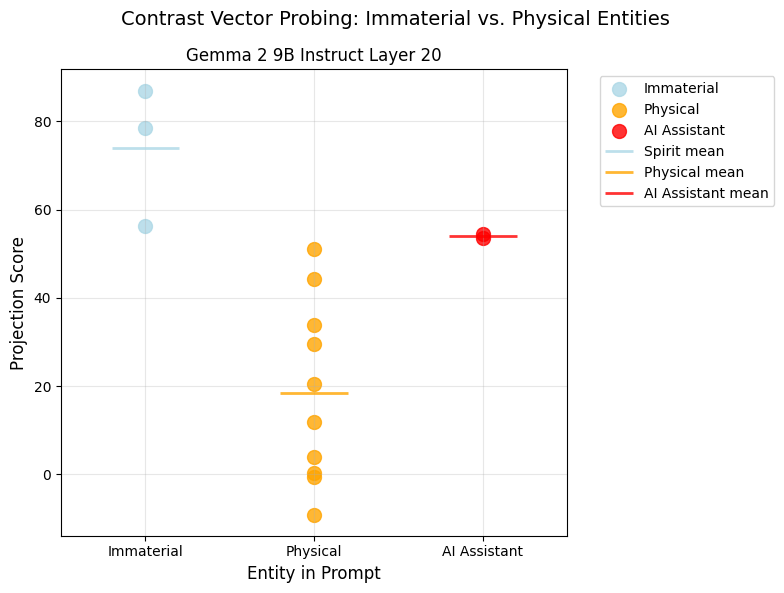

In [39]:
# Strip plot showing all individual points
plt.figure(figsize=(8, 6))

labels = ['Immaterial', 'Physical', 'AI Assistant']

plt.scatter([1]*len(positive_projections), positive_projections, 
            color='lightblue', alpha=0.8, s=100, label='Immaterial')
plt.scatter([2]*len(negative_projections), negative_projections, 
            color='orange', alpha=0.8, s=100, label='Physical')
plt.scatter([3]*len(assistant_projections), assistant_projections, 
            color='red', alpha=0.8, s=100, label='AI Assistant')

# # Add mean lines
plt.hlines(np.mean(positive_projections), 0.8, 1.2, colors='lightblue', linewidth=2, alpha=0.8, label='Spirit mean')
plt.hlines(np.mean(negative_projections), 1.8, 2.2, colors='orange', linewidth=2, alpha=0.8, label='Physical mean')
plt.hlines(np.mean(assistant_projections), 2.8, 3.2, colors='red', linewidth=2, alpha=0.8, label='AI Assistant mean')

plt.xticks([1, 2, 3], labels)
plt.ylabel('Projection Score', fontsize=12)
plt.xlabel('Entity in Prompt', fontsize=12)
plt.title(f'{MODEL_READABLE} Layer {LAYER}', fontsize=12)
plt.suptitle(f'Contrast Vector Probing: Immaterial vs. Physical Entities', fontsize=14)
plt.grid(True, alpha=0.3)

# Add some spacing around the plot
plt.xlim(0.5, 3.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# plt.savefig(OUTPUT_NAME)